In [52]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.layouts import column
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix



df = pd.read_csv('stroke_dataset.csv')

df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [53]:
df.shape

(4981, 11)

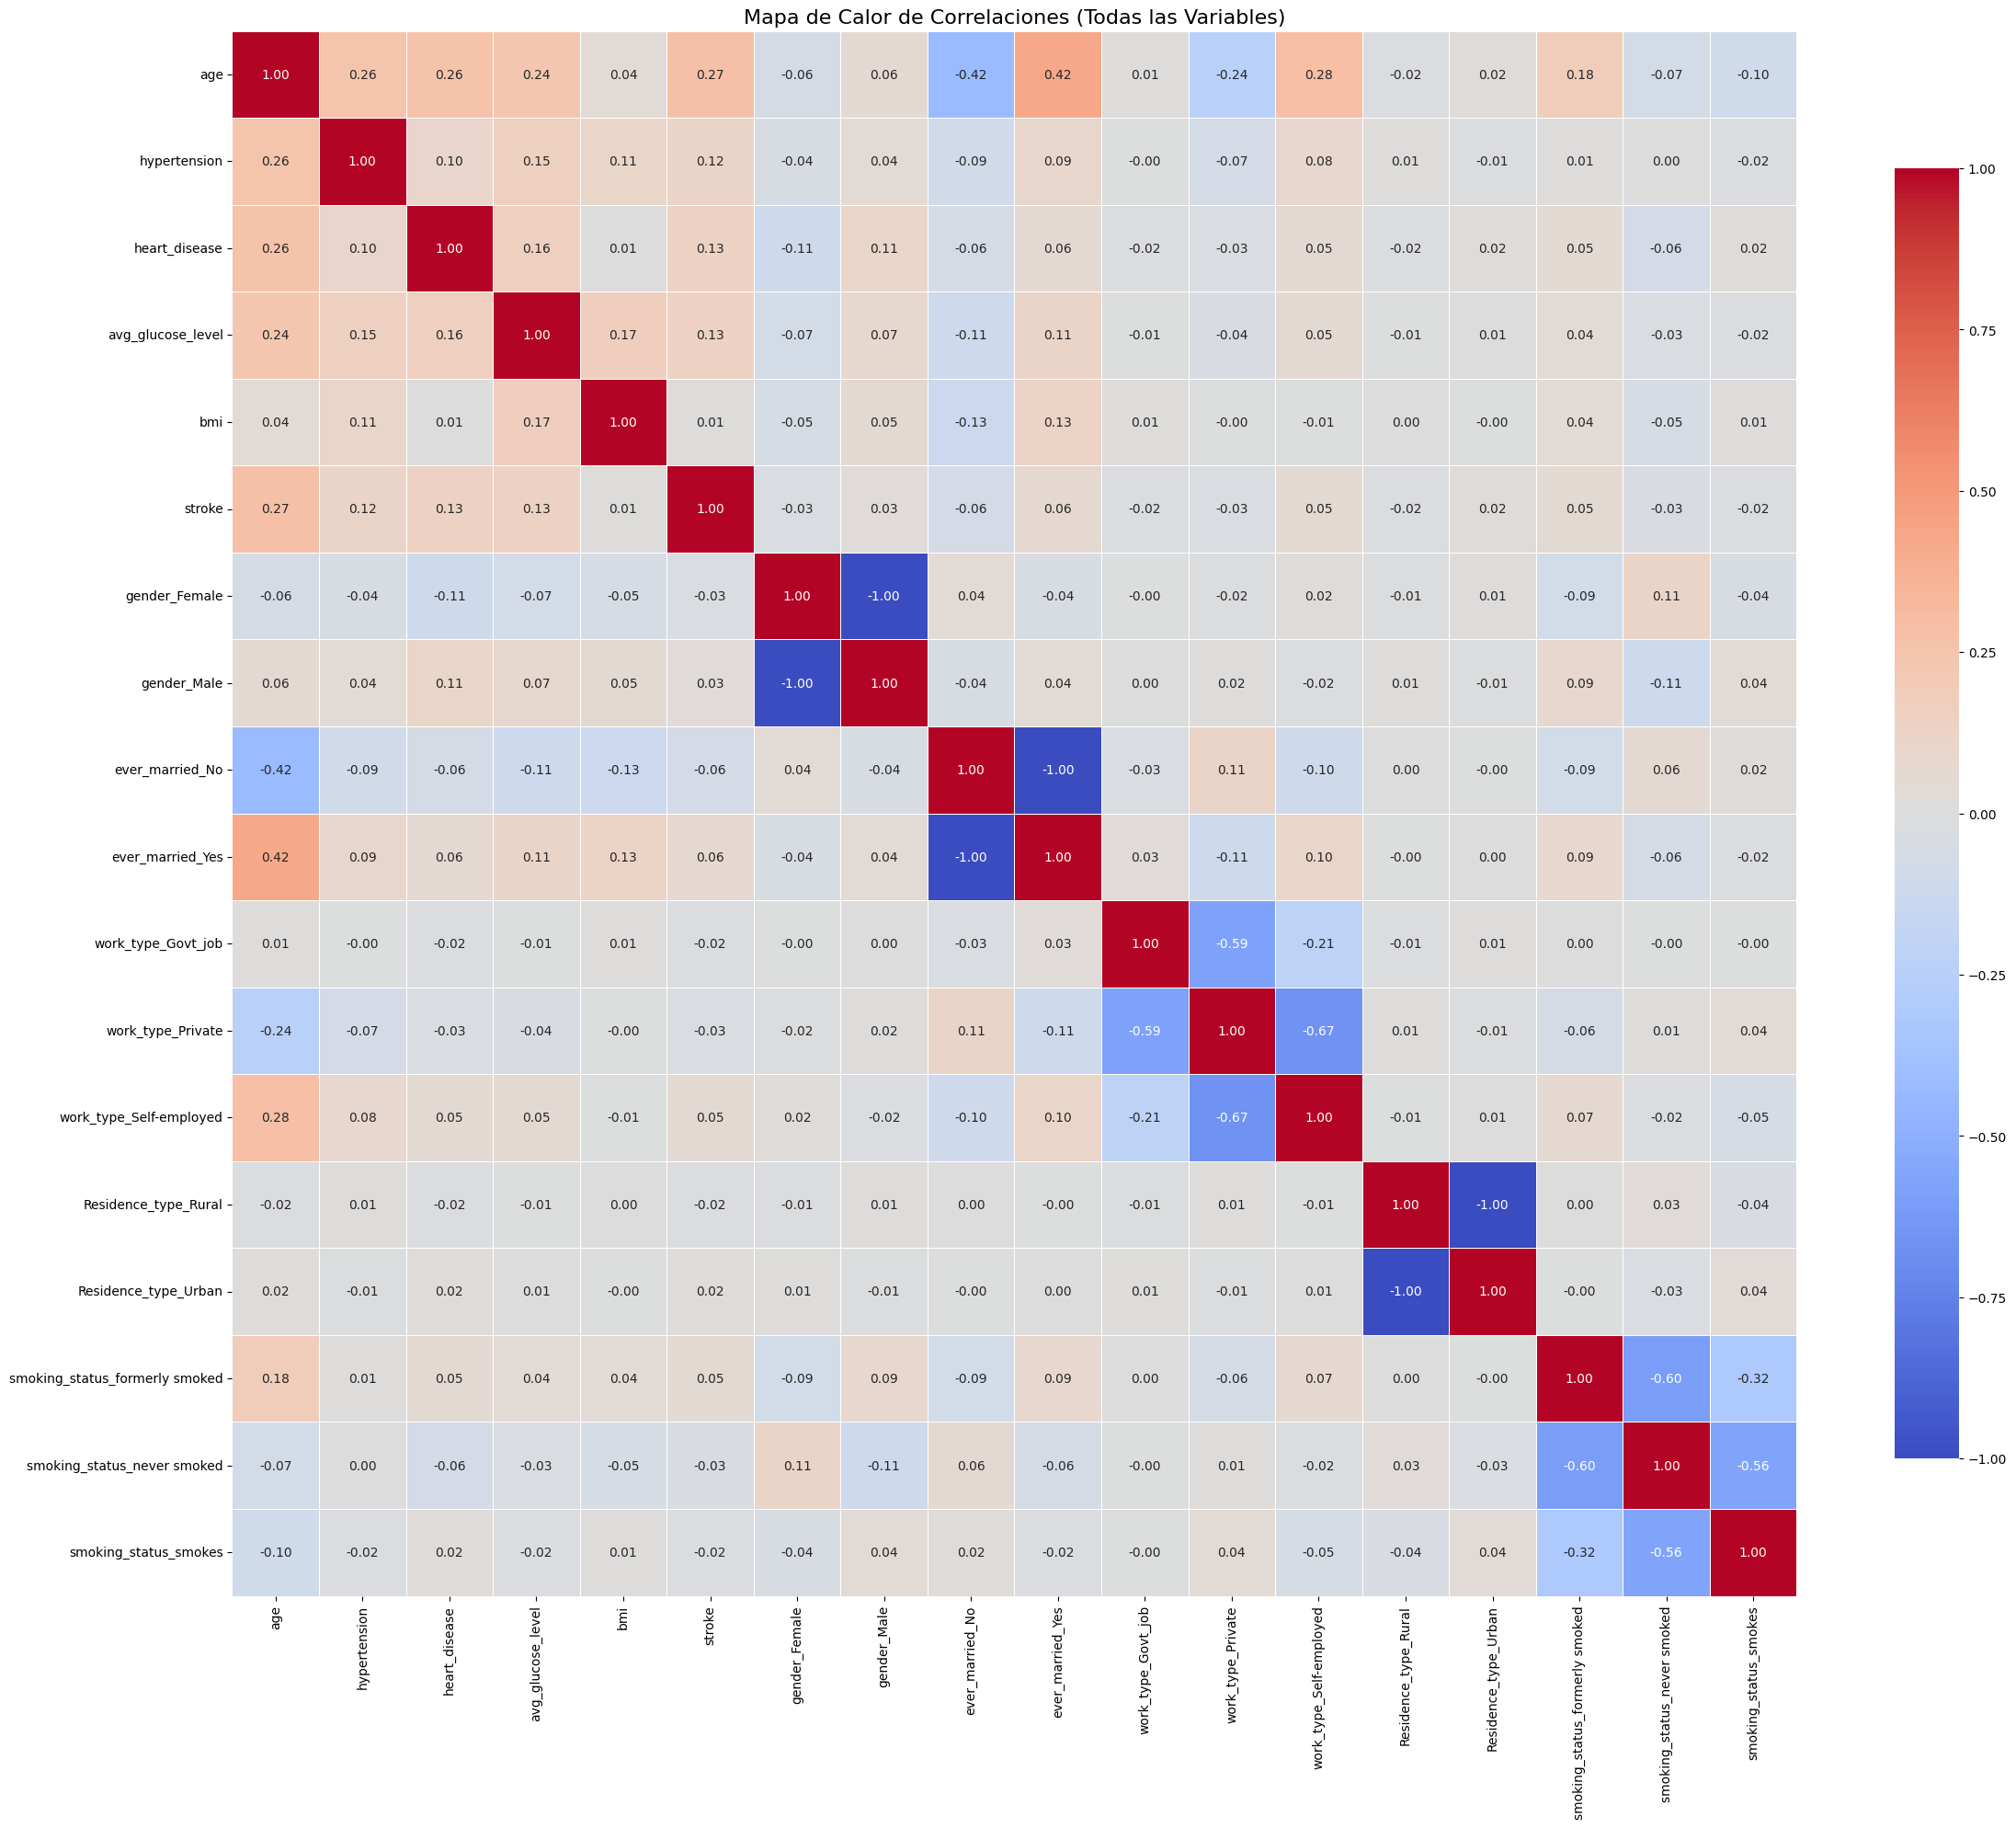

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Codificación one-hot para variables categóricas
df_encoded = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Crear el mapa de calor con valores
plt.figure(figsize=(24, 20))  # Aumentado el tamaño para mejor visibilidad
sns.heatmap(correlation_matrix, 
            annot=True,  # Esto muestra los valores
            fmt='.2f',   # Formato de dos decimales
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            square=True,  # Hace que los cuadrados sean perfectamente cuadrados
            linewidths=.5,  # Añade líneas entre los cuadrados
            cbar_kws={"shrink": .8})  # Ajusta el tamaño de la barra de color

plt.title('Mapa de Calor de Correlaciones (Todas las Variables)', fontsize=16)
plt.tight_layout()
plt.show()


In [54]:
# Eliminar registros donde la edad es menor a 18 años
df = df[df['age'] >= 18]

# Separar los datos en dos grupos: stroke = 0 y stroke = 1
df_no_stroke = df[df['stroke'] == 0]
df_stroke = df[df['stroke'] == 1]

# Eliminar 'Unknown' de smoking_status donde stroke = 0
df_no_stroke = df_no_stroke[df_no_stroke['smoking_status'] != 'Unknown']

# Calcular la distribución de smoking_status para stroke = 1 (excluyendo 'Unknown')
smoking_dist = df_stroke[df_stroke['smoking_status'] != 'Unknown']['smoking_status'].value_counts(normalize=True)

# Identificar los registros con stroke = 1 y smoking_status = 'Unknown'
unknown_stroke = df_stroke[df_stroke['smoking_status'] == 'Unknown']

# Imputar valores para los 'Unknown' en stroke = 1
np.random.seed(42)  # Para reproducibilidad
imputed_values = np.random.choice(smoking_dist.index, size=len(unknown_stroke), p=smoking_dist.values)
unknown_stroke['smoking_status'] = imputed_values

# Combinar los dataframes
df_stroke_imputed = pd.concat([df_stroke[df_stroke['smoking_status'] != 'Unknown'], unknown_stroke])
df_final = pd.concat([df_no_stroke, df_stroke_imputed])

# Verificar los resultados
print("Distribución original de smoking_status:")
print(df['smoking_status'].value_counts(normalize=True))
print("\nDistribución de smoking_status después de la imputación:")
print(df_final['smoking_status'].value_counts(normalize=True))
print("\nNúmero de registros con stroke = 1:")
print(df_final['stroke'].value_counts()[1])

# Guardar el nuevo dataset
df_final.to_csv("stroke_dataset_processed.csv", index=False)

Distribución original de smoking_status:
smoking_status
never smoked       0.411255
formerly smoked    0.202501
Unknown            0.201780
smokes             0.184464
Name: proportion, dtype: float64

Distribución de smoking_status después de la imputación:
smoking_status
never smoked       0.515458
formerly smoked    0.254162
smokes             0.230380
Name: proportion, dtype: float64

Número de registros con stroke = 1:
246


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18352\1898471618.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_stroke['smoking_status'] = imputed_values


In [55]:
df = pd.read_csv('stroke_dataset_processed.csv')

In [56]:
# Crear una lista para almacenar los gráficos
plots = []

# Iterar sobre cada columna numérica
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    # Crear un histograma
    hist, edges = np.histogram(df[col].dropna(), bins=30)
    
    # Crear la figura
    p = figure(title=f'Histograma de {col}', x_axis_label=col, y_axis_label='Frecuencia')
    
    # Añadir el histograma a la figura
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.7)
    
    # Añadir la figura a la lista de gráficos
    plots.append(p)

# Mostrar todos los histogramas en una columna
show(column(plots))

In [57]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


# Paso 2: Identificar columnas categóricas y numéricas
categorical_columns = ['gender', 'smoking_status']
numeric_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']

# Paso 3: Preparar X e y
X = df.drop('stroke', axis=1)
y = df['stroke']

# Paso 4: Crear y aplicar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(sparse_output=False), categorical_columns)
    ])

# Ajustar y transformar X
X_transformed = preprocessor.fit_transform(X)

# Obtener los nombres de las columnas después del preprocesamiento
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_columns)
feature_names = numeric_columns + list(cat_feature_names)

# Crear un nuevo DataFrame con las características transformadas
X_new = pd.DataFrame(X_transformed, columns=feature_names)

# Paso 5: Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, stratify=y)

# Paso 6: Aplicar NearMiss
nm = NearMiss(version=3, n_neighbors=3)
X_resampled, y_resampled = nm.fit_resample(X_train, y_train)

# Convertir X_resampled de nuevo a DataFrame
X_resampled_df = pd.DataFrame(X_resampled, columns=X_new.columns)

print("\nForma del conjunto de datos rebalanceado:")
print(X_resampled_df.shape)

# Imprimir información sobre el balanceo
print("\nDistribución original de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases después de NearMiss:")
print(pd.Series(y_resampled).value_counts(normalize=True))

# Mostrar las primeras filas del DataFrame rebalanceado
print("\nPrimeras filas del conjunto de datos rebalanceado:")
print(X_resampled_df.head())


Forma del conjunto de datos rebalanceado:
(394, 9)

Distribución original de clases en el conjunto de entrenamiento:
stroke
0    0.926793
1    0.073207
Name: proportion, dtype: float64

Distribución de clases después de NearMiss:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Primeras filas del conjunto de datos rebalanceado:
        age  hypertension  heart_disease  avg_glucose_level  gender_Female  \
0  0.564675       2.60174       3.648958           0.792873            0.0   
1  0.112707       2.60174       3.648958           0.000494            0.0   
2  1.638100       2.60174       3.648958          -0.466586            0.0   
3  0.508179       2.60174       3.648958           1.872496            0.0   
4  0.508179       2.60174       3.648958           2.265924            1.0   

   gender_Male  smoking_status_formerly smoked  smoking_status_never smoked  \
0          1.0                             1.0                          0.0   
1          1.0                  

In [59]:
resultado_final = X_resampled_df.copy()
resultado_final['stroke'] = y_resampled

# Guardar el DataFrame en un archivo CSV
resultado_final.to_csv('stroke_dataset_processed_balanced.csv', index=False)

print("Dataset procesado y balanceado guardado como 'stroke_dataset_processed_balanced.csv'")

Dataset procesado y balanceado guardado como 'stroke_dataset_processed_balanced.csv'
